In [87]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom as dcm
%matplotlib inline 
plt.set_cmap(plt.cm.bone)
IS_LOCAL = True
import os
import cv2
import skimage
from skimage import feature, filters
from tqdm import tqdm

<Figure size 432x288 with 0 Axes>

In [88]:
PATH="D:/Dowloads"

In [89]:
class_info_df = pd.read_csv(PATH+'/stage_2_detailed_class_info.csv')
train_labels_df = pd.read_csv(PATH+'/stage_2_train_labels.csv')
train_class_df = train_labels_df.merge(class_info_df, left_on='patientId', right_on='patientId', how='inner')

In [90]:
train_class_df.head()

,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity


# Utility functions

In [91]:
def load_images(data):
    imgs = []
    for path in data['patientId']:
        patientImage = path + '.dcm'
        imagePath = os.path.join(PATH,"stage_2_train_images/", patientImage)
        img = dcm.read_file(imagePath).pixel_array
        imgs.append(img)
    return imgs

def imshow_gray(img):
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')
    
def imshow_with_labels(img, patient_id):
    rows = train_labels_df[train_labels_df['patientId'] == patient_id]
    for row in rows.itertuples():        
        x, y, w, h = row.x, row.y, row.width, row.height
        x, y, w, h = map(int, [x,y,w,h])
        cv2.rectangle(img, (x,y), (x+w,y+h), 255, 2)
    plt.figure(figsize=(12,7))
    return plt.imshow(img, cmap='gray')

# Sample a few images and process them

In [92]:
test_df = train_class_df[train_class_df['Target']==1].sample(4)
box = test_df.loc[test_df.index, ['x', 'y', 'width', 'height']]
test = load_images(test_df[0:3])

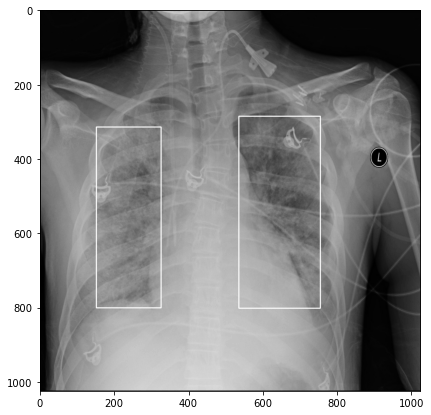

In [93]:
idx = 1
img = test[idx]
imshow_with_labels(img.copy(), test_df.iloc[idx,0])

# Image Enhancement

## Histogram Equalization

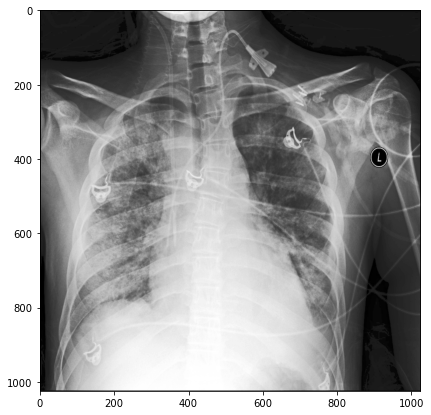

In [94]:
equ = cv2.equalizeHist(test[idx])
ax = imshow_gray(equ)

# Image sharpening

Text(0.5, 0.98, 'Image sharpening')

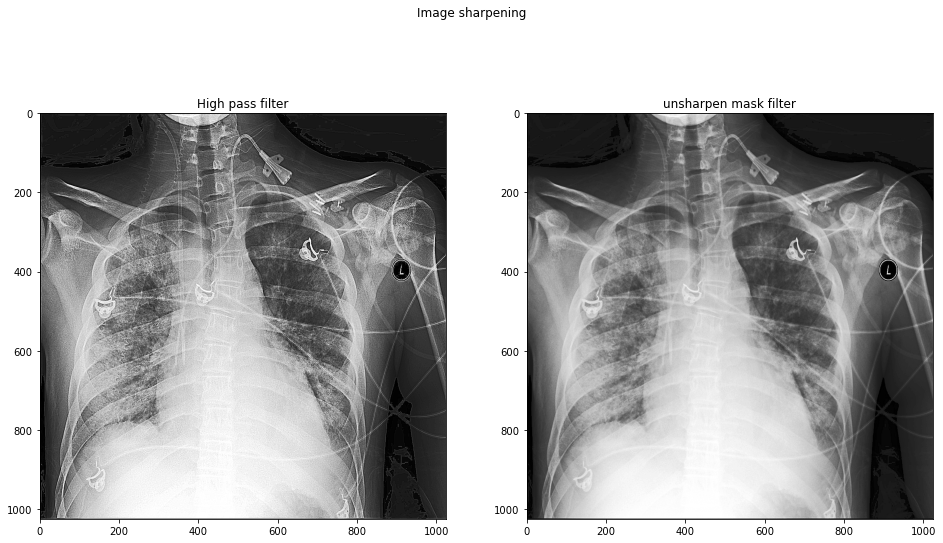

In [95]:
# apply hpf kernel
hpf_kernel = np.full((3, 3), -1)
hpf_kernel[1,1] = 9
im_hp = cv2.filter2D(equ, -1, hpf_kernel)

# use unsharpen mask filter
im_us = skimage.filters.unsharp_mask(equ)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(im_hp, cmap='gray')
ax1.set_title('High pass filter')
ax2.imshow(im_us, cmap='gray')
ax2.set_title('unsharpen mask filter')
fig.suptitle('Image sharpening')

# Thresholding

Text(0.5, 0.98, 'Image thresholding')

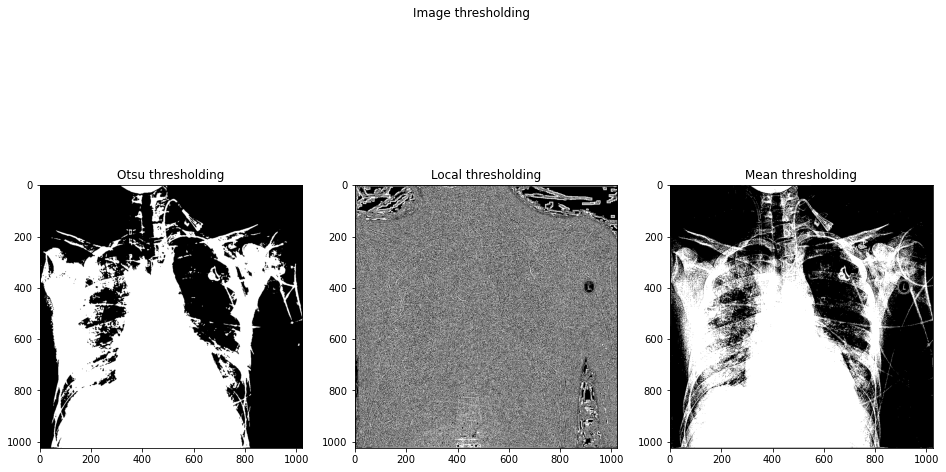

In [96]:
# otsu thresholding
ret, otsu = cv2.threshold(cv2.GaussianBlur(im_hp,(7,7),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# local thresholding
local = im_hp > skimage.filters.threshold_local(im_hp, 5)
mean = im_hp > skimage.filters.threshold_mean(im_hp)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,9))
ax1.imshow(otsu, cmap='gray')
ax1.set_title('Otsu thresholding')
ax2.imshow(local, cmap='gray')
ax2.set_title('Local thresholding')
fig.suptitle('Image sharpening')
ax3.imshow(mean, cmap='gray')
ax3.set_title('Mean thresholding')
fig.suptitle('Image thresholding')

# Edge detection

Text(0.5, 0.98, 'Edge detection')

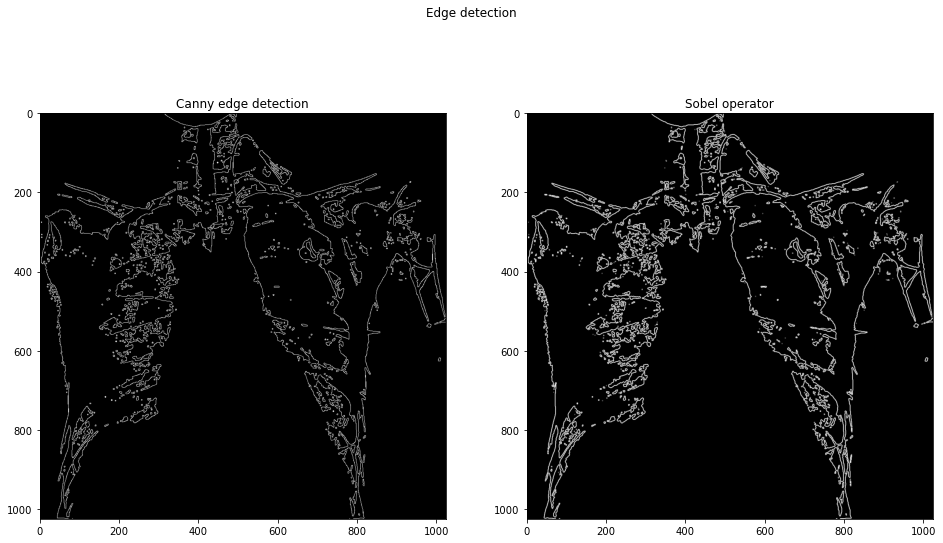

In [97]:
sobel = filters.sobel(otsu)
canny = feature.canny(otsu/255)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
ax1.imshow(canny, cmap='gray')
ax1.set_title('Canny edge detection')
ax2.imshow(sobel, cmap='gray')
ax2.set_title('Sobel operator')
fig.suptitle('Edge detection')

# Lung segmentation

Contours found  279


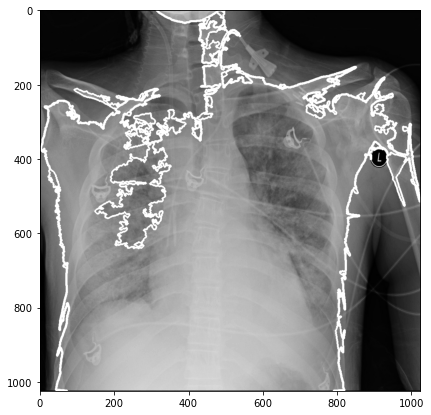

In [98]:
contours, hier = cv2.findContours((sobel * 255).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
print('Contours found ', len(contours))

srt_contours = sorted(contours, key=lambda x: x.shape[0], reverse=True)
select_contour = srt_contours[0]

test = img.copy()
img_contour = cv2.drawContours(test, [select_contour], 0, (255,0,0), thickness=3)

imshow_gray(img_contour)

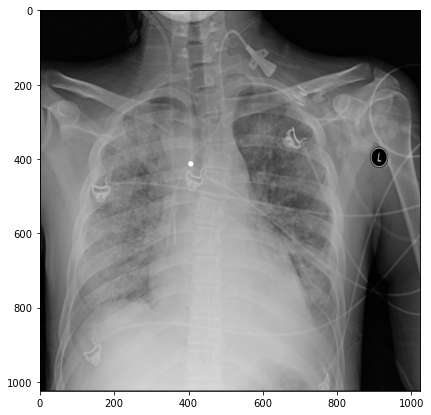

In [99]:
M = cv2.moments(select_contour)
cx = int(M['m10'] / M['m00'])
cy = int(M["m01"] / M["m00"])

test = img.copy()
cv2.circle(test, (cx, cy), 7, (255, 255, 255), -1)
imshow_gray(test)

In [100]:
def get_hu_moments(contour):
    M = cv2.moments(select_contour)
    hu = cv2.HuMoments(M).ravel().tolist()
    del hu[2]
    del hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu

get_hu_moments(select_contour)

[-0.2855522760429979,
 0.1982343221090278,
 -0.4944195765717464,
 -0.7911400099012931,
 -0.2943319580733965]

# Feature extraction

In [101]:
def area(img):
    # binarized image as input
    return np.count_nonzero(img) 

def perimeter(img):
    # edges of the image as input
    return np.count_nonzero(img)

def irregularity(area, perimeter):
    # area and perimeter of the image as input, also called compactness
    I = (4 * np.pi * area) / (perimeter ** 2)
    return I

def equiv_diam(area):
    # area of image as input
    ed = np.sqrt((4 * area) / np.pi)
    return ed

def get_hu_moments(contour):
    # hu moments except 3rd and 7th (5 values)
    M = cv2.moments(contour)
    hu = cv2.HuMoments(M).ravel().tolist()
    del hu[2]
    del hu[-1]
    log_hu = [-np.sign(a)*np.log10(np.abs(a)) for a in hu]
    return log_hu

### The image preprocessing and feature extraction pipeline

In [102]:
def extract_features(img):
    mean = img.mean()
    std_dev = img.std()
    
    # hist equalization
    equalized = cv2.equalizeHist(img)
    
    # sharpening
    hpf_kernel = np.full((3, 3), -1)
    hpf_kernel[1,1] = 9
    sharpened = cv2.filter2D(equalized, -1, hpf_kernel)
    
    # thresholding
    ret, binarized = cv2.threshold(cv2.GaussianBlur(sharpened,(7,7),0),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    # edge detection
    edges = skimage.filters.sobel(binarized)
    
    # moments from contours
    contours, hier = cv2.findContours((edges * 255).astype('uint8'),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    select_contour = sorted(contours, key=lambda x: x.shape[0], reverse=True)[0]
    
    # feature extraction
    ar = area(binarized)
    per = perimeter(edges)
    irreg = irregularity(ar, per)
    eq_diam = equiv_diam(ar)
    hu = get_hu_moments(select_contour)
    
    return (mean, std_dev, ar, per, irreg, eq_diam, *hu)

In [103]:
# test the function
extract_features(img)

(115.43908786773682,
 57.776814873730736,
 519996,
 75724,
 0.0011395746330946411,
 813.6826594588985,
 -0.2855522760429979,
 0.1982343221090278,
 -0.4944195765717464,
 -0.7911400099012931,
 -0.2943319580733965)

# Model building

## Load the required data

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
pneumonia_ids = train_labels_df[train_labels_df['Target'] == 1]['patientId'].unique()
pneumonia_labels = [1] * len(pneumonia_ids)

normal_ids = class_info_df[class_info_df['class'] == 'Normal']['patientId'].unique()
normal_labels = [0] * len(normal_ids)

data = dict()
data['patientId'] = np.concatenate((pneumonia_ids, normal_ids))
data['target'] = np.concatenate((pneumonia_labels, normal_labels))

print(f'Pneumonia images: {len(pneumonia_ids)}\nNormal images: {len(normal_ids)}')

Pneumonia images: 6012
Normal images: 8851


## Generate features

In [106]:
from tqdm import tqdm

In [107]:
features = []

for path in tqdm(data['patientId']):
    patientImage = path + '.dcm'
    imagePath = os.path.join(PATH,"stage_2_train_images/", patientImage)
    img = dcm.read_file(imagePath).pixel_array
    feats = extract_features(img)
    features.append(feats)

data['features'] = features

100%|████████████████████████████████████████████████████████████████████████████| 14863/14863 [14:39<00:00, 16.90it/s]


In [108]:
df = pd.DataFrame(data)
df.to_csv('img_features.csv')

In [109]:
from sklearn.model_selection import train_test_split

In [110]:
np.random.seed(42)

In [111]:
data = pd.read_csv('img_features.csv')
data.head()

,Unnamed: 0,patientId,target,features
0,0,00436515-870c-4b36-a041-de91049b9ab4,1,"(115.08454608917236, 57.27438506263394, 529785..."
1,1,00704310-78a8-4b38-8475-49f4573b2dbb,1,"(92.81453704833984, 74.93762038175163, 498500,..."
2,2,00aecb01-a116-45a2-956c-08d2fa55433f,1,"(38.749732971191406, 51.14731838178627, 328949..."
3,3,00c0b293-48e7-4e16-ac76-9269ba535a62,1,"(104.95982074737549, 70.30975599712868, 487539..."
4,4,00f08de1-517e-4652-a04f-d1dc9ee48593,1,"(110.65030765533447, 58.128343368363296, 52948..."


In [112]:
feats = data.features.apply(lambda x: list(eval(x)))
dataset = pd.DataFrame(feats.values.tolist(), 
                        columns=['mean', 'stddev', 'area', 'perimeter', 'irregularity', 'equiv_diam', 'hu1', 'hu2', 'hu4', 'hu5', 'hu6'],
                       index=data.index)
dataset['label'] = data['target']
dataset.head()

,mean,stddev,area,perimeter,irregularity,equiv_diam,hu1,hu2,hu4,hu5,hu6,label
0,115.084546,57.274385,529785,32447,0.006324,821.305797,-0.696690,-0.727353,-1.364790,2.242547,1.444623,1
1,92.814537,74.937620,498500,33992,0.005422,796.686835,-0.786889,-1.159396,-2.403345,-4.952226,-2.793199,1
2,38.749733,51.147318,328949,23970,0.007195,647.171442,0.774458,3.230857,6.683296,-12.330389,-8.355217,1
3,104.959821,70.309756,487539,46375,0.002849,787.879391,-0.467952,1.008866,-0.450719,0.560254,0.571350,1
4,110.650308,58.128343,529486,58260,0.001960,821.074000,-0.557977,-0.910131,-0.957654,-1.977245,-1.399643,1


In [113]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('label', axis=1), dataset['label'],
                                                   test_size=0.4, stratify=dataset['label'])

In [114]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

def print_metrics(y_pred, y_train, yt_pred, y_test):
    print('Train data metrics:')
    print('Accuracy: ', accuracy_score(y_train, y_pred))
    print('Precison: ', precision_score(y_train, y_pred))
    print('Recall: ', recall_score(y_train, y_pred))
    print('F1 score: ', f1_score(y_train, y_pred))
    print('ROC AUC score: ', roc_auc_score(y_train, y_pred))
    print()
    print('Test data metrics:')
    print('Accuracy: ', accuracy_score(y_test, yt_pred))
    print('Precison: ', precision_score(y_test, yt_pred))
    print('Recall: ', recall_score(y_test, yt_pred))
    print('F1 score: ', f1_score(y_test, yt_pred))
    print('ROC AUC score: ', roc_auc_score(y_test, yt_pred))

In [115]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

print_metrics(lr.predict(X_train), y_train, lr.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.6598631826847594
Precison:  0.6411012782694199
Recall:  0.3615192680898253
F1 score:  0.4623293742244282
ROC AUC score:  0.6120214042897338

Test data metrics:
Accuracy:  0.6626303397241843
Precison:  0.659217877094972
Recall:  0.34345114345114347
F1 score:  0.4516129032258065
ROC AUC score:  0.6114318693816011


In [116]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(500, max_depth=8, min_samples_split=2,
                            n_jobs=-1)
rf.fit(X_train, y_train)

print_metrics(rf.predict(X_train), y_train, rf.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.8253897050577549
Precison:  0.8227329974811083
Recall:  0.724424729692265
F1 score:  0.7704555506413091
ROC AUC score:  0.8091991821719329

Test data metrics:
Accuracy:  0.7803565422132526
Precison:  0.762291169451074
Recall:  0.664033264033264
F1 score:  0.7097777777777778
ROC AUC score:  0.761697513123664


In [117]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01,
                               max_depth=7, min_samples_split=5)
gb.fit(X_train, y_train)

print_metrics(gb.predict(X_train), y_train, gb.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.8897611304250308
Precison:  0.8890865954922894
Recall:  0.8311616301635708
F1 score:  0.8591488751970197
ROC AUC score:  0.8803642425770773

Test data metrics:
Accuracy:  0.7954927682475614
Precison:  0.7693701857725419
Recall:  0.7060291060291061
F1 score:  0.7363399826539462
ROC AUC score:  0.7811422005717402


In [118]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train, y_train)

print_metrics(svm.predict(X_train), y_train, svm.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.6562745317932039
Precison:  0.7178456591639871
Recall:  0.24757416135292487
F1 score:  0.3681715110286539
ROC AUC score:  0.5907362332188354

Test data metrics:
Accuracy:  0.6505213588967373
Precison:  0.7188755020080321
Recall:  0.2232848232848233
F1 score:  0.3407360406091371
ROC AUC score:  0.5819897711453769


In [120]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(20)
knn.fit(X_train, y_train)

print_metrics(knn.predict(X_train), y_train, knn.predict(X_test), y_test)

Train data metrics:
Accuracy:  0.7262532241785353
Precison:  0.7094109195402298
Recall:  0.5475464374826726
F1 score:  0.6180566421530277
ROC AUC score:  0.697596194259227

Test data metrics:
Accuracy:  0.7058526740665994
Precison:  0.6814159292035398
Recall:  0.5122661122661123
F1 score:  0.5848563968668408
ROC AUC score:  0.6748000993411895


C:\Users\Yashas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
C:\Users\Yashas\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:251: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(
C:\Users\Yashas\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:251: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(
C:\Users\Yashas\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:309: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(
C:\Users\Yashas\anaconda3\lib\site-packages\yellowbrick\classifier\base.py:309: YellowbrickWarning: both classes and encoder specified, using encoder
  warnings.warn(


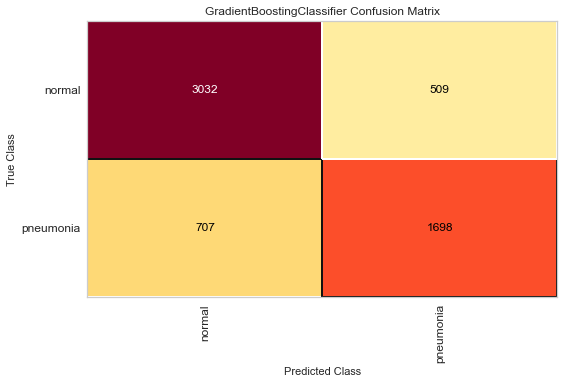

<AxesSubplot:title={'center':'GradientBoostingClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [121]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(gb, classes=[0,1], encoder={0: 'normal', 1: 'pneumonia'})
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

C:\Users\Yashas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


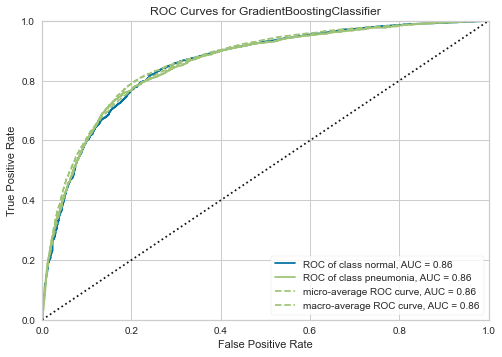

<AxesSubplot:title={'center':'ROC Curves for GradientBoostingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [122]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(gb, classes=["normal", "pneumonia"])

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test) 
visualizer.show()    

C:\Users\Yashas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


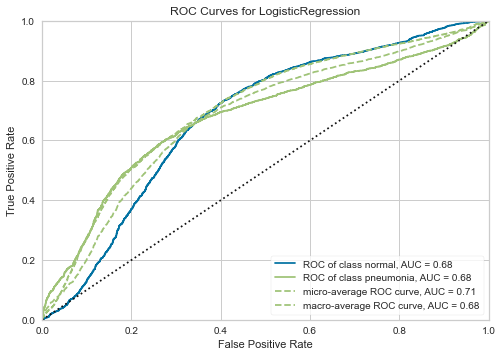

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [124]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(lr, classes=["normal", "pneumonia"])

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test) 
visualizer.show()

C:\Users\Yashas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


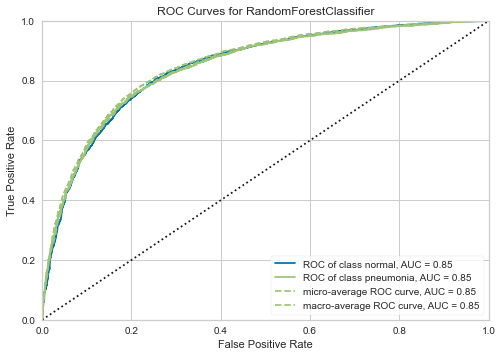

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [125]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["normal", "pneumonia"])

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test) 
visualizer.show()  

C:\Users\Yashas\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


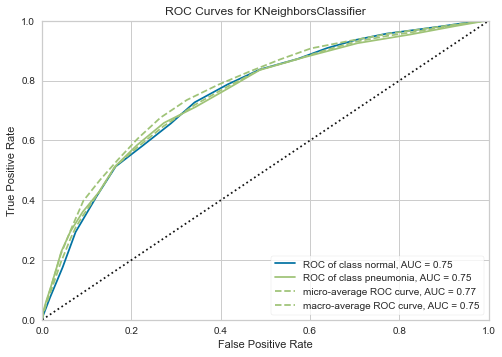

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [127]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(knn, classes=["normal", "pneumonia"])

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test) 
visualizer.show()  

Feature ranking:
1. feature 1 (0.206304)
2. feature 3 (0.156620)
3. feature 4 (0.139899)
4. feature 5 (0.098836)
5. feature 2 (0.095705)
6. feature 0 (0.081777)
7. feature 6 (0.070414)
8. feature 8 (0.053884)
9. feature 7 (0.032927)
10. feature 9 (0.032775)
11. feature 10 (0.030860)


(-1.0, 11.0)

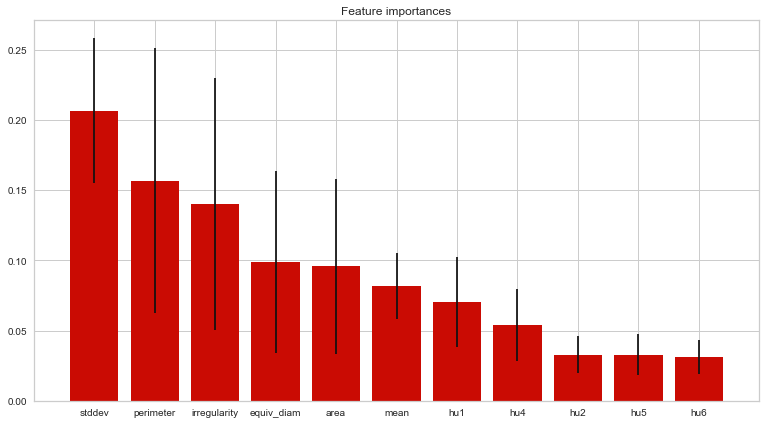

In [123]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(figsize=(13,7))
plt.title("Feature importances")

plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])

In [53]:
import skimage